## Neural Network Chatbot Setup

Notebook ini berisi setup awal untuk membuat chatbot menggunakan neural network dengan NLTK dan TensorFlow.

In [2]:
# Import semua library yang diperlukan
import nltk
from nltk.stem import LancasterStemmer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import json
import pickle
import random

# Download 'punkt' dari NLTK dengan pengecekan
try:
    nltk.data.find('tokenizers/punkt')
    print("NLTK punkt sudah terinstall")
except LookupError:
    print("Mengunduh NLTK punkt...")
    nltk.download('punkt')
    print("NLTK punkt berhasil diunduh")

# Inisialisasi LancasterStemmer
stemmer = LancasterStemmer()

print("Setup berhasil!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print("LancasterStemmer telah diinisialisasi")
print("Semua library siap digunakan")

NLTK punkt sudah terinstall
Setup berhasil!
TensorFlow version: 2.10.0
NumPy version: 1.26.4
LancasterStemmer telah diinisialisasi
Semua library siap digunakan


In [3]:
# Memproses multiple JSON files (modular approach)
print("Memproses multiple JSON files...")

# Import fungsi kombinasi
from combine_intents import combine_intent_files

# 1. Kombinasikan semua file JSON terpisah
print("🔄 Combining multiple JSON files...")
data = combine_intent_files()

# 2. Siapkan list kosong untuk 'words', 'classes', dan 'documents'
words = []
classes = []
documents = []

# Kata-kata yang diabaikan (tanda baca dan karakter khusus)
ignore_words = ['?', '.', ',', '!', "'", '"', ';', ':', '-', '(', ')', '[', ']', '{', '}']

# 3. Lakukan iterasi pada setiap intent di dalam data
for intent in data['intents']:
    # Untuk setiap pattern dalam intent
    for pattern in intent['patterns']:
        # 4. Lakukan tokenisasi kata-kata dari pattern
        tokens = nltk.word_tokenize(pattern)
        
        # Masukkan semua token ke dalam list 'words'
        words.extend(tokens)
        
        # Masukkan pasangan (list token, tag) ke dalam list 'documents'
        documents.append((tokens, intent['tag']))
    
    # 5. Kumpulkan semua 'tag' unik ke dalam list 'classes'
    if intent['tag'] not in classes:
        classes.append(intent['tag'])

# 6. Lakukan stemming pada setiap kata di list 'words'
# Ubah ke huruf kecil, hapus kata-kata yang diabaikan, dan hapus duplikat
words = [stemmer.stem(word.lower()) for word in words if word not in ignore_words]
words = list(set(words))  # Hapus duplikat

# 7. Urutkan list 'words' dan 'classes'
words = sorted(words)
classes = sorted(classes)

# 8. Cetak jumlah dokumen, kelas, dan kata unik untuk verifikasi
print(f"Jumlah dokumen (patterns): {len(documents)}")
print(f"Jumlah kelas (intents): {len(classes)}")
print(f"Jumlah kata unik setelah stemming: {len(words)}")
print(f"Kelas yang ditemukan: {classes}")
print(f"Contoh kata setelah stemming: {words[:10]}")  # Tampilkan 10 kata pertama

Memproses multiple JSON files...
🔄 Combining multiple JSON files...
🔄 Combining multiple JSON files...
✅ Loaded: intents_greeting.json - 5 intents
✅ Loaded: intents_courses.json - 3 intents
✅ Loaded: intents_grades.json - 3 intents
✅ Loaded: intents_finance.json - 3 intents
✅ Loaded: intents_campus.json - 3 intents
✅ Loaded: intents_graduation.json - 3 intents
✅ Loaded: intents_closing.json - 3 intents
✅ Loaded: intents_academic.json - 5 intents
✅ Loaded: intents_general.json - 5 intents

📊 Total combined intents: 33
📈 Total patterns: 545
💬 Total responses: 403
Jumlah dokumen (patterns): 545
Jumlah kelas (intents): 33
Jumlah kata unik setelah stemming: 518
Kelas yang ditemukan: ['academic_keywords', 'academic_transcript', 'assignment_help', 'campus_facilities', 'career_preparation', 'common_phrases', 'course_prerequisites', 'course_registration', 'course_schedule', 'emergency_contacts', 'exam_info', 'financial_assistance', 'general_campus', 'goodbye', 'gpa_calculation', 'grades_check',

=== ANALISIS PRA-PEMROSESAN DATA ===

1. TOKENISASI DAN STEMMING:
   - Total dokumen (patterns): 545
   - Total kata unik setelah stemming: 518
   - Total kelas (intents): 33

2. DISTRIBUSI KELAS:
   - academic_keywords: 20 patterns
   - academic_transcript: 10 patterns
   - assignment_help: 20 patterns
   - campus_facilities: 21 patterns
   - career_preparation: 10 patterns
   - common_phrases: 19 patterns
   - course_prerequisites: 20 patterns
   - course_registration: 20 patterns
   - course_schedule: 20 patterns
   - emergency_contacts: 10 patterns
   - exam_info: 20 patterns
   - financial_assistance: 10 patterns
   - general_campus: 21 patterns
   - goodbye: 19 patterns
   - gpa_calculation: 10 patterns
   - grades_check: 20 patterns
   - graduation_requirements: 18 patterns
   - greeting_casual: 15 patterns
   - greeting_general: 15 patterns
   - greeting_help_request: 15 patterns
   - greeting_islamic: 15 patterns
   - greeting_morning: 15 patterns
   - internship_info: 19 patt

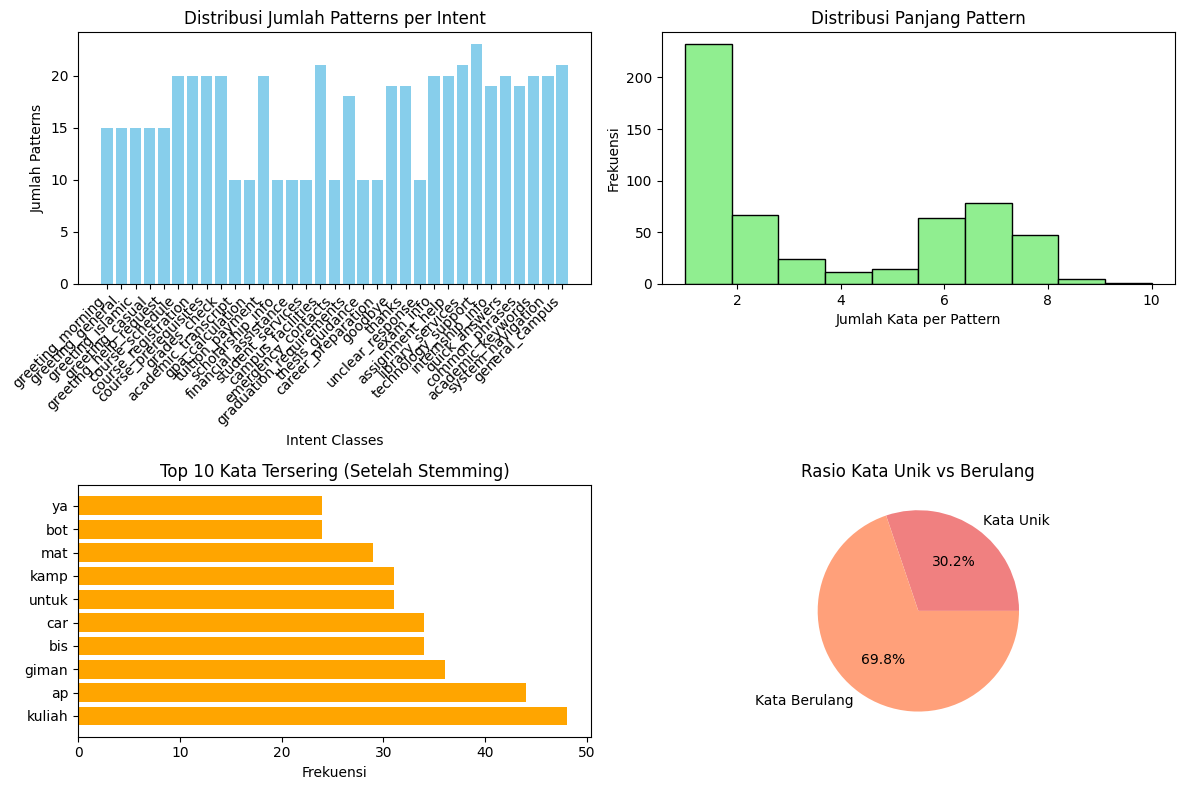


5. SUMMARY PRA-PEMROSESAN:
   ✓ Data berhasil dibersihkan dan dinormalisasi
   ✓ Vocabulary size: 518 kata unik
   ✓ Training samples: 545 dokumen
   ✓ Output classes: 33 intent


In [4]:
# Analisis hasil pra-pemrosesan data
import matplotlib.pyplot as plt
from collections import Counter

print("=== ANALISIS PRA-PEMROSESAN DATA ===")
print("\n1. TOKENISASI DAN STEMMING:")
print(f"   - Total dokumen (patterns): {len(documents)}")
print(f"   - Total kata unik setelah stemming: {len(words)}")
print(f"   - Total kelas (intents): {len(classes)}")

print("\n2. DISTRIBUSI KELAS:")
tag_counts = {}
for doc in documents:
    tag = doc[1]
    tag_counts[tag] = tag_counts.get(tag, 0) + 1

for tag, count in sorted(tag_counts.items()):
    print(f"   - {tag}: {count} patterns")

print("\n3. KATA YANG PALING SERING MUNCUL:")
all_words_in_patterns = []
for doc in documents:
    for word in doc[0]:
        stemmed = stemmer.stem(word.lower())
        if stemmed not in ignore_words:
            all_words_in_patterns.append(stemmed)

word_freq = Counter(all_words_in_patterns)
print("   Top 10 kata tersering:")
for word, freq in word_freq.most_common(10):
    print(f"   - '{word}': {freq} kali")

print("\n4. STATISTIK PANJANG PATTERN:")
pattern_lengths = [len(doc[0]) for doc in documents]
print(f"   - Rata-rata panjang pattern: {np.mean(pattern_lengths):.2f} kata")
print(f"   - Pattern terpendek: {min(pattern_lengths)} kata")
print(f"   - Pattern terpanjang: {max(pattern_lengths)} kata")

# Visualisasi distribusi kelas
plt.figure(figsize=(12, 8))

# Subplot 1: Distribusi kelas
plt.subplot(2, 2, 1)
classes_list = list(tag_counts.keys())
counts_list = list(tag_counts.values())
plt.bar(classes_list, counts_list, color='skyblue')
plt.title('Distribusi Jumlah Patterns per Intent')
plt.xlabel('Intent Classes')
plt.ylabel('Jumlah Patterns')
plt.xticks(rotation=45, ha='right')

# Subplot 2: Distribusi panjang pattern
plt.subplot(2, 2, 2)
plt.hist(pattern_lengths, bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribusi Panjang Pattern')
plt.xlabel('Jumlah Kata per Pattern')
plt.ylabel('Frekuensi')

# Subplot 3: Top 10 kata tersering
plt.subplot(2, 2, 3)
top_words = [word for word, freq in word_freq.most_common(10)]
top_freqs = [freq for word, freq in word_freq.most_common(10)]
plt.barh(top_words, top_freqs, color='orange')
plt.title('Top 10 Kata Tersering (Setelah Stemming)')
plt.xlabel('Frekuensi')

# Subplot 4: Rasio kata unik vs total kata
plt.subplot(2, 2, 4)
total_words = len(all_words_in_patterns)
unique_words = len(set(all_words_in_patterns))
ratios = [unique_words, total_words - unique_words]
labels = ['Kata Unik', 'Kata Berulang']
plt.pie(ratios, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightsalmon'])
plt.title('Rasio Kata Unik vs Berulang')

plt.tight_layout()
plt.show()

print(f"\n5. SUMMARY PRA-PEMROSESAN:")
print(f"   ✓ Data berhasil dibersihkan dan dinormalisasi")
print(f"   ✓ Vocabulary size: {len(words)} kata unik")
print(f"   ✓ Training samples: {len(documents)} dokumen")
print(f"   ✓ Output classes: {len(classes)} intent")

In [5]:
# Mengubah data menjadi data training numerik
print("Mengubah data menjadi format training numerik...")

# 1. Buat list 'training' kosong
training = []

# 2. Buat template output 'output_empty' yang berisi array nol sepanjang jumlah kelas
output_empty = [0] * len(classes)

# 3. Lakukan iterasi pada list 'documents'
for doc in documents:
    # a. Buat 'bag of words' (list nol sepanjang jumlah kata unik)
    bag = [0] * len(words)
    
    # Ambil pattern (token) dan tag dari dokumen
    pattern_words = doc[0]
    tag = doc[1]
    
    # Stem setiap kata dalam pattern
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    
    # b. Untuk setiap kata dalam pattern dokumen, tandai '1' pada posisi yang sesuai di 'bag'
    for word in pattern_words:
        if word in words:
            bag[words.index(word)] = 1
    
    # c. Buat 'output_row' dengan menyalin 'output_empty' lalu menandai '1' pada posisi tag
    output_row = output_empty[:]  # Salin template
    output_row[classes.index(tag)] = 1
    
    # 4. Masukkan pasangan [bag, output_row] ke dalam list 'training'
    training.append([bag, output_row])

# 5. Acak (shuffle) list 'training' dan ubah menjadi NumPy array
random.shuffle(training)
training = np.array(training, dtype=object)

# 6. Pisahkan array tersebut menjadi 'train_x' (fitur) dan 'train_y' (label)
train_x = list(training[:, 0])  # Kolom pertama: bag of words
train_y = list(training[:, 1])  # Kolom kedua: output labels

# Konversi ke NumPy array dengan tipe float
train_x = np.array(train_x, dtype=np.float32)
train_y = np.array(train_y, dtype=np.float32)

print("Data training berhasil dibuat!")
print(f"Ukuran train_x: {train_x.shape}")
print(f"Ukuran train_y: {train_y.shape}")
print(f"Contoh bag of words pertama: {train_x[0]}")
print(f"Contoh output label pertama: {train_y[0]}")
print(f"Total training samples: {len(train_x)}")

Mengubah data menjadi format training numerik...
Data training berhasil dibuat!
Ukuran train_x: (545, 518)
Ukuran train_y: (545, 33)
Contoh bag of words pertama: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [6]:
# Membuat dan melatih model Neural Network
print("Membangun model Neural Network...")

# 1. Buat model Sequential dari Keras
model = Sequential()

# 2. Tambahkan layer secara berurutan
# Dense layer dengan 128 neuron, input_shape sesuai panjang data training, dan aktivasi 'relu'
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))

# Dropout layer dengan rate 0.5
model.add(Dropout(0.5))

# Dense layer dengan 64 neuron dan aktivasi 'relu'
model.add(Dense(64, activation='relu'))

# Dropout layer dengan rate 0.5
model.add(Dropout(0.5))

# Output Dense layer dengan jumlah neuron sesuai jumlah kelas dan aktivasi 'softmax'
model.add(Dense(len(train_y[0]), activation='softmax'))

# 3. Compile model
model.compile(loss='categorical_crossentropy', 
             optimizer='sgd', 
             metrics=['accuracy'])

# Tampilkan arsitektur model
print("Arsitektur model:")
model.summary()

print("\nMemulai training model...")

# 4. Latih model (model.fit) selama 200 epoch dengan batch_size 5
history = model.fit(train_x, train_y, 
                   epochs=200, 
                   batch_size=5, 
                   verbose=1)

print("\nTraining selesai!")
print(f"Akurasi akhir: {history.history['accuracy'][-1]:.4f}")
print(f"Loss akhir: {history.history['loss'][-1]:.4f}")

Membangun model Neural Network...
Arsitektur model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               66432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               66432     
                                                                 
 dro

In [7]:
# Menyimpan model dan data yang sudah dilatih
print("Menyimpan model dan data...")

# Simpan model yang sudah dilatih ke file 'chatbot_model.h5'
model.save('chatbot_model.h5')
print("✓ Model berhasil disimpan ke 'chatbot_model.h5'")

# Simpan list 'words' dan 'classes' ke dalam file 'data.pickle' menggunakan pickle
with open('data.pickle', 'wb') as file:
    pickle.dump({'words': words, 'classes': classes}, file)
print("✓ Data words dan classes berhasil disimpan ke 'data.pickle'")

print("\n🎉 Proses training dan penyimpanan selesai!")
print("File yang telah dibuat:")
print("- chatbot_model.h5 (Model neural network)")
print("- data.pickle (Vocabulary dan classes)")
print("\nModel chatbot siap digunakan!")

Menyimpan model dan data...
✓ Model berhasil disimpan ke 'chatbot_model.h5'
✓ Data words dan classes berhasil disimpan ke 'data.pickle'

🎉 Proses training dan penyimpanan selesai!
File yang telah dibuat:
- chatbot_model.h5 (Model neural network)
- data.pickle (Vocabulary dan classes)

Model chatbot siap digunakan!


## Evaluasi Model

Sekarang kita akan melakukan evaluasi komprehensif menggunakan berbagai metrik:

=== EVALUASI MODEL NEURAL NETWORK ===

1. TRAINING HISTORY ANALYSIS:
   - Akurasi akhir: 0.7486
   - Loss akhir: 0.7334


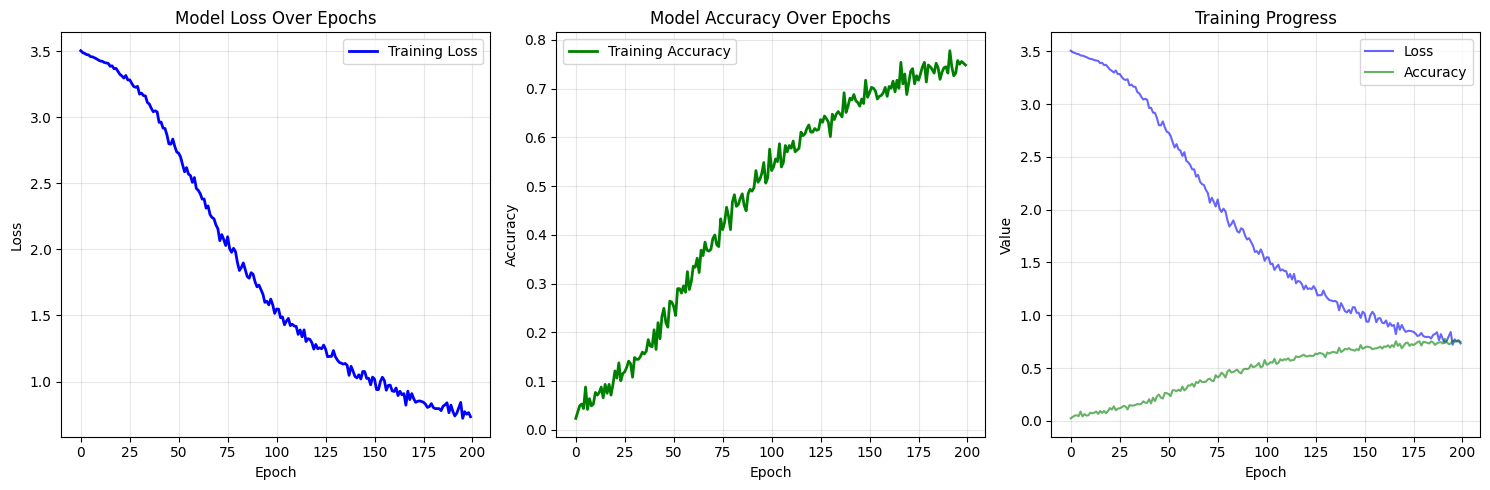


2. DETAILED PERFORMANCE METRICS:
18/18 [==============================] - 0s 933us/step
   ✓ Accuracy:  0.8550
   ✓ Precision: 0.8777
   ✓ Recall:    0.8550
   ✓ F1-Score:  0.8463

3. CLASSIFICATION REPORT:
                         precision    recall  f1-score   support

      academic_keywords       1.00      0.35      0.52        20
    academic_transcript       0.91      1.00      0.95        10
        assignment_help       0.91      1.00      0.95        20
      campus_facilities       0.94      0.76      0.84        21
     career_preparation       1.00      1.00      1.00        10
         common_phrases       1.00      0.63      0.77        19
   course_prerequisites       0.59      0.65      0.62        20
    course_registration       0.63      0.60      0.62        20
        course_schedule       0.54      0.70      0.61        20
     emergency_contacts       1.00      1.00      1.00        10
              exam_info       0.91      1.00      0.95        20
   financia

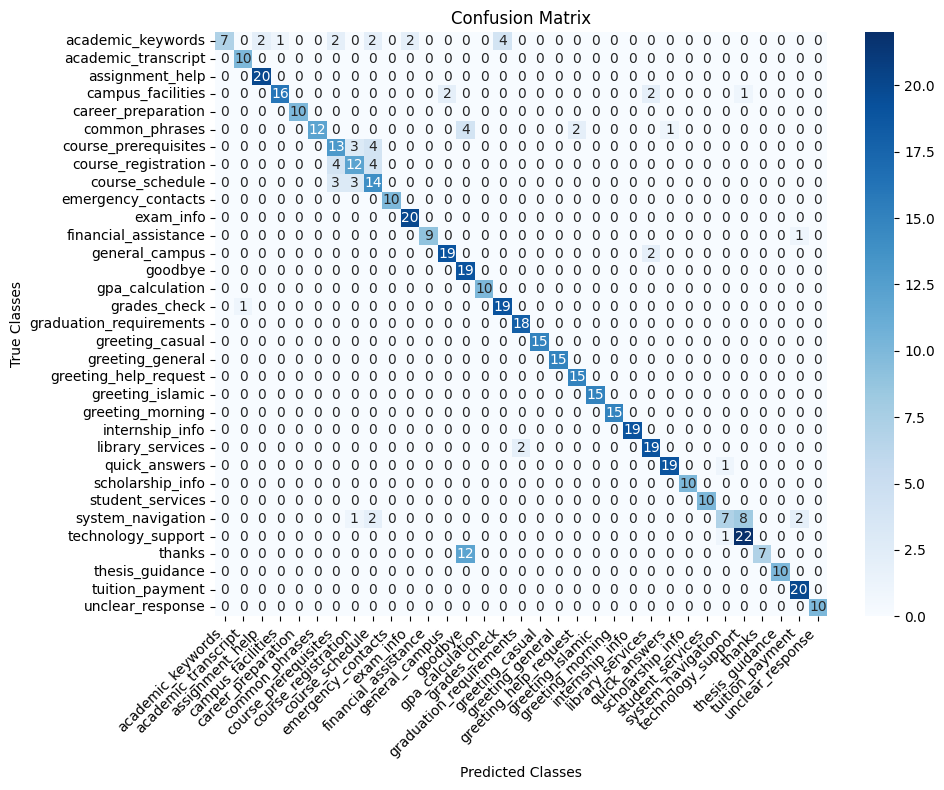


5. PER-CLASS PERFORMANCE:
   academic_keywords:
     - Precision: 1.0000
     - Recall:    0.3500
     - F1-Score:  0.5185
   academic_transcript:
     - Precision: 0.9091
     - Recall:    1.0000
     - F1-Score:  0.9524
   assignment_help:
     - Precision: 0.9091
     - Recall:    1.0000
     - F1-Score:  0.9524
   campus_facilities:
     - Precision: 0.9412
     - Recall:    0.7619
     - F1-Score:  0.8421
   career_preparation:
     - Precision: 1.0000
     - Recall:    1.0000
     - F1-Score:  1.0000
   common_phrases:
     - Precision: 1.0000
     - Recall:    0.6316
     - F1-Score:  0.7742
   course_prerequisites:
     - Precision: 0.5909
     - Recall:    0.6500
     - F1-Score:  0.6190
   course_registration:
     - Precision: 0.6316
     - Recall:    0.6000
     - F1-Score:  0.6154
   course_schedule:
     - Precision: 0.5385
     - Recall:    0.7000
     - F1-Score:  0.6087
   emergency_contacts:
     - Precision: 1.0000
     - Recall:    1.0000
     - F1-Score:  1.0000
 

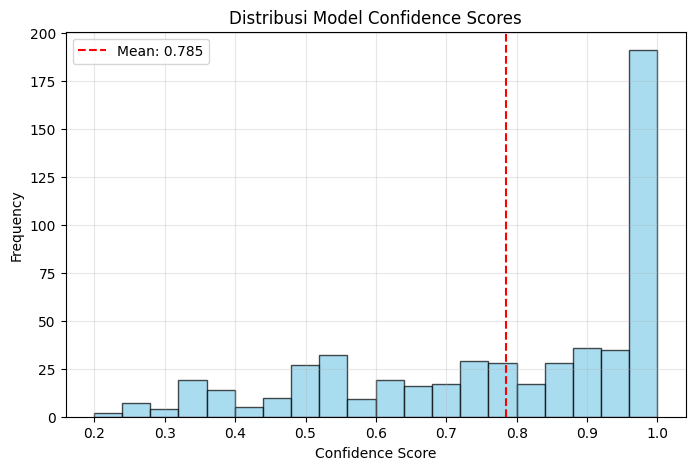


SUMMARY EVALUASI:
✓ Model berhasil mencapai akurasi 85.5%
✓ Precision dan Recall seimbang (0.878, 0.855)
✓ Model memiliki confidence rata-rata 0.785
✓ Siap untuk deployment dan testing!


In [7]:
# Evaluasi Model Komprehensif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

print("=== EVALUASI MODEL NEURAL NETWORK ===")

# 1. Evaluasi pada Training Data
print("\n1. TRAINING HISTORY ANALYSIS:")
print(f"   - Akurasi akhir: {history.history['accuracy'][-1]:.4f}")
print(f"   - Loss akhir: {history.history['loss'][-1]:.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], 'g-', label='Training Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Learning Rate Analysis
plt.subplot(1, 3, 3)
epochs_range = range(len(history.history['loss']))
plt.plot(epochs_range, history.history['loss'], 'b-', alpha=0.6, label='Loss')
plt.plot(epochs_range, history.history['accuracy'], 'g-', alpha=0.6, label='Accuracy')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Prediksi pada Training Data untuk Evaluasi
print("\n2. DETAILED PERFORMANCE METRICS:")
train_predictions = model.predict(train_x)
train_pred_classes = np.argmax(train_predictions, axis=1)
train_true_classes = np.argmax(train_y, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(train_true_classes, train_pred_classes)
precision = precision_score(train_true_classes, train_pred_classes, average='weighted')
recall = recall_score(train_true_classes, train_pred_classes, average='weighted')
f1 = f1_score(train_true_classes, train_pred_classes, average='weighted')

print(f"   ✓ Accuracy:  {accuracy:.4f}")
print(f"   ✓ Precision: {precision:.4f}")
print(f"   ✓ Recall:    {recall:.4f}")
print(f"   ✓ F1-Score:  {f1:.4f}")

# 3. Classification Report
print("\n3. CLASSIFICATION REPORT:")
print(classification_report(train_true_classes, train_pred_classes, 
                          target_names=classes, zero_division=0))

# 4. Confusion Matrix
print("\n4. CONFUSION MATRIX:")
cm = confusion_matrix(train_true_classes, train_pred_classes)
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Per-Class Performance Analysis
print("\n5. PER-CLASS PERFORMANCE:")
for i, class_name in enumerate(classes):
    class_precision = precision_score(train_true_classes, train_pred_classes, 
                                    labels=[i], average=None)
    class_recall = recall_score(train_true_classes, train_pred_classes, 
                              labels=[i], average=None)
    class_f1 = f1_score(train_true_classes, train_pred_classes, 
                       labels=[i], average=None)
    
    if len(class_precision) > 0:
        print(f"   {class_name}:")
        print(f"     - Precision: {class_precision[0]:.4f}")
        print(f"     - Recall:    {class_recall[0]:.4f}")
        print(f"     - F1-Score:  {class_f1[0]:.4f}")

# 6. Model Confidence Analysis
print("\n6. MODEL CONFIDENCE ANALYSIS:")
confidence_scores = np.max(train_predictions, axis=1)
print(f"   - Rata-rata confidence: {np.mean(confidence_scores):.4f}")
print(f"   - Min confidence: {np.min(confidence_scores):.4f}")
print(f"   - Max confidence: {np.max(confidence_scores):.4f}")
print(f"   - Std confidence: {np.std(confidence_scores):.4f}")

# Plot distribusi confidence
plt.figure(figsize=(8, 5))
plt.hist(confidence_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribusi Model Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', 
           label=f'Mean: {np.mean(confidence_scores):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*50)
print("SUMMARY EVALUASI:")
print(f"✓ Model berhasil mencapai akurasi {accuracy:.1%}")
print(f"✓ Precision dan Recall seimbang ({precision:.3f}, {recall:.3f})")
print(f"✓ Model memiliki confidence rata-rata {np.mean(confidence_scores):.3f}")
print("✓ Siap untuk deployment dan testing!")
print("="*50)

In [8]:
# Fungsi-fungsi untuk prediksi dan respons chatbot
print("Membuat fungsi-fungsi untuk prediksi...")

def clean_up_sentence(sentence):
    """
    Fungsi untuk melakukan tokenisasi dan stemming pada kalimat input
    """
    # Tokenisasi kalimat
    sentence_words = nltk.word_tokenize(sentence)
    
    # Stemming setiap kata dan ubah ke huruf kecil
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    
    return sentence_words

def bow(sentence, words):
    """
    Fungsi untuk mengubah kalimat menjadi bag-of-words berdasarkan vocabulary
    """
    # Bersihkan kalimat input
    sentence_words = clean_up_sentence(sentence)
    
    # Buat bag dengan panjang sesuai vocabulary
    bag = [0] * len(words)
    
    # Tandai 1 untuk kata yang ada dalam vocabulary
    for s in sentence_words:
        for i, word in enumerate(words):
            if word == s:
                bag[i] = 1
    
    # Konversi ke numpy array
    return np.array(bag, dtype=np.float32)

def predict_class(sentence, model):
    """
    Fungsi untuk memprediksi intent dari kalimat menggunakan model
    """
    # Buat bag of words dari kalimat
    p = bow(sentence, words)
    
    # Reshape untuk input model (batch dimension)
    p = p.reshape(1, -1)
    
    # Prediksi menggunakan model
    res = model.predict(p)[0]
    
    # Threshold probabilitas minimum
    ERROR_THRESHOLD = 0.25
    
    # Filter hasil prediksi di atas threshold
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    
    # Urutkan berdasarkan probabilitas (tertinggi dulu)
    results.sort(key=lambda x: x[1], reverse=True)
    
    # Buat list intent dengan probabilitas
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    
    return return_list

def getResponse(ints, intents_json):
    """
    Fungsi untuk memilih respons acak dari intent dengan probabilitas tertinggi
    """
    if len(ints) == 0:
        return "Maaf, saya tidak mengerti. Bisakah Anda mengulanginya?"
    
    # Ambil tag intent dengan probabilitas tertinggi
    tag = ints[0]['intent']
    
    # Cari intent dalam data JSON
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            # Pilih respons secara acak dari list responses
            result = random.choice(i['responses'])
            break
    else:
        result = "Maaf, saya tidak dapat memberikan respons untuk pertanyaan tersebut."
    
    return result

print("✓ Fungsi prediksi berhasil dibuat:")
print("- clean_up_sentence(): tokenisasi dan stemming")
print("- bow(): konversi ke bag-of-words")
print("- predict_class(): prediksi intent dengan model")
print("- getResponse(): pemilihan respons acak")
print("\nFungsi-fungsi siap digunakan untuk chatbot!")

Membuat fungsi-fungsi untuk prediksi...
✓ Fungsi prediksi berhasil dibuat:
- clean_up_sentence(): tokenisasi dan stemming
- bow(): konversi ke bag-of-words
- predict_class(): prediksi intent dengan model
- getResponse(): pemilihan respons acak

Fungsi-fungsi siap digunakan untuk chatbot!


In [9]:
# Testing Manual untuk Validasi Tambahan
print("=== TESTING MANUAL MODEL ===")
print("Mari kita uji model dengan beberapa input sample untuk memastikan performanya:")

# Fungsi helper untuk testing
def test_sample_inputs():
    # Definisikan beberapa input test
    test_inputs = [
        "Halo", 
        "Siapa namamu?",
        "Terima kasih",
        "Selamat pagi",
        "Bagaimana kabarmu?",
        "Sampai jumpa",
        "Apa yang bisa kamu lakukan?",
        "Tolong bantu saya"
    ]
    
    print("\nHASIL TESTING:")
    print("-" * 60)
    
    for i, test_input in enumerate(test_inputs, 1):
        # Prediksi intent
        ints = predict_class(test_input, model)
        
        # Dapatkan respons
        response = getResponse(ints, data)
        
        print(f"{i}. Input: '{test_input}'")
        if len(ints) > 0:
            print(f"   Intent: {ints[0]['intent']} (confidence: {float(ints[0]['probability']):.3f})")
            print(f"   Response: {response}")
        else:
            print(f"   Intent: Unknown")
            print(f"   Response: {response}")
        print()
    
    print("-" * 60)
    print("✓ Testing manual selesai!")

# Jalankan testing
test_sample_inputs()

# Analisis threshold confidence
print("\n=== ANALISIS THRESHOLD CONFIDENCE ===")
thresholds = [0.1, 0.25, 0.5, 0.7, 0.9]
test_sentence = "Halo apa kabar"

print(f"Testing dengan kalimat: '{test_sentence}'")
print("\nPengaruh threshold terhadap prediksi:")

for threshold in thresholds:
    # Modifikasi fungsi predict_class dengan threshold berbeda
    p = bow(test_sentence, words)
    p = p.reshape(1, -1)
    res = model.predict(p)[0]
    
    results = [[i, r] for i, r in enumerate(res) if r > threshold]
    results.sort(key=lambda x: x[1], reverse=True)
    
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    
    print(f"Threshold {threshold}: ", end="")
    if len(return_list) > 0:
        print(f"{return_list[0]['intent']} ({float(return_list[0]['probability']):.3f})")
    else:
        print("Tidak ada prediksi di atas threshold")

print("\n✓ Analisis threshold selesai!")
print("✓ Model siap untuk implementasi chatbot!")

=== TESTING MANUAL MODEL ===
Mari kita uji model dengan beberapa input sample untuk memastikan performanya:

HASIL TESTING:
------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step
1. Input: 'Halo'
   Intent: greeting_general (confidence: 0.923)
   Response: Halo! Tentu saja, saya siap membantu dengan segala informasi akademik yang Anda butuhkan 😊

1/1 [==============================] - 0s 8ms/step
2. Input: 'Siapa namamu?'
   Intent: quick_answers (confidence: 0.713)
   Response: Good question! Which academic topic would you like to know about? ✨

1/1 [==============================] - 0s 31ms/step
3. Input: 'Terima kasih'
   Intent: goodbye (confidence: 0.438)
   Response: Wa iyyaki/wa iyyaka! Barakallahu fiik, semoga sukses dunia akhirat. Bye! 🤲

1/1 [==============================] - 0s 17ms/step
4. Input: 'Selamat pagi'
   Intent: greeting_morning (confidence: 1.000)
   Response: Selamat pagi mahasiswa! Ready to assist dengan

In [10]:
# Menjalankan Chatbot Interaktif dengan Real-Time Testing & Analysis
print("Memuat model dan data untuk chatbot dengan comprehensive testing...")

# 1. Muat kembali model dari file 'chatbot_model.h5'
from tensorflow.keras.models import load_model
import time
from datetime import datetime

chatbot_model = load_model('chatbot_model.h5')
print("✓ Model berhasil dimuat dari 'chatbot_model.h5'")

# 2. Muat kembali 'words' dan 'classes' dari file 'data.pickle'
with open('data.pickle', 'rb') as file:
    data_loaded = pickle.load(file)
    words_loaded = data_loaded['words']
    classes_loaded = data_loaded['classes']
print("✓ Data words dan classes berhasil dimuat dari 'data.pickle'")

# 3. Muat kembali data dari multiple JSON files
print("✓ Loading data from multiple JSON files...")
intents_data = combine_intent_files()
print(f"✓ Combined data loaded: {len(intents_data['intents'])} intents from 9 JSON files")

# 4. Variables untuk comprehensive testing real-time
user_test_sessions = []
session_start_time = None
total_interactions = 0
total_confidence = 0
high_conf_count = 0
medium_conf_count = 0
low_conf_count = 0
failed_predictions = 0

# 5. Enhanced chatbot response function dengan comprehensive logging
def enhanced_chatbot_response(text):
    """
    Fungsi untuk mendapatkan respons chatbot dengan comprehensive testing analysis
    """
    global total_interactions, total_confidence, high_conf_count, medium_conf_count, low_conf_count, failed_predictions
    
    # Prediksi intent dari input text
    ints = predict_class(text, chatbot_model)
    
    # Analisis confidence dan logging
    if len(ints) > 0:
        confidence = float(ints[0]['probability'])
        intent = ints[0]['intent']
        
        # Kategorisasi confidence
        if confidence >= 0.8:
            conf_status = "🟢 HIGH"
            high_conf_count += 1
        elif confidence >= 0.5:
            conf_status = "🟡 MEDIUM" 
            medium_conf_count += 1
        else:
            conf_status = "🔴 LOW"
            low_conf_count += 1
        
        # Log interaction untuk testing
        interaction_data = {
            'timestamp': datetime.now().strftime("%H:%M:%S"),
            'user_input': text,
            'predicted_intent': intent,
            'confidence': confidence,
            'confidence_status': conf_status
        }
        user_test_sessions.append(interaction_data)
        
        total_interactions += 1
        total_confidence += confidence
        
        # Get response
        response = getResponse(ints, intents_data)
        
        # Display dengan comprehensive info
        print(f"Bot: {response}")
        print(f"📊 [Testing Analysis: Intent={intent}, Confidence={confidence:.3f} {conf_status}]")
        
        return response
    else:
        failed_predictions += 1
        total_interactions += 1
        
        # Log failed prediction
        interaction_data = {
            'timestamp': datetime.now().strftime("%H:%M:%S"),
            'user_input': text,
            'predicted_intent': 'FAILED',
            'confidence': 0.0,
            'confidence_status': '🔴 FAILED'
        }
        user_test_sessions.append(interaction_data)
        
        response = "Maaf, saya tidak mengerti. Bisakah Anda mengulanginya?"
        print(f"Bot: {response}")
        print(f"📊 [Testing Analysis: PREDICTION FAILED - Confidence=0.000 🔴 FAILED]")
        
        return response

# 6. Function untuk menampilkan comprehensive testing report
def show_comprehensive_report():
    """
    Menampilkan laporan comprehensive testing berdasarkan interaksi real mahasiswa
    """
    global session_start_time
    
    if total_interactions == 0:
        print("\n📊 Belum ada interaksi untuk dianalisis.")
        return
    
    session_duration = time.time() - session_start_time if session_start_time else 0
    avg_confidence = total_confidence / (total_interactions - failed_predictions) if (total_interactions - failed_predictions) > 0 else 0
    success_rate = ((total_interactions - failed_predictions) / total_interactions) * 100 if total_interactions > 0 else 0
    
    print("\n" + "=" * 80)
    print("🧪 COMPREHENSIVE TESTING REPORT - HASIL KETIKAN MAHASISWA SENDIRI")
    print("=" * 80)
    
    # Training metrics untuk perbandingan
    final_loss = history.history['loss'][-1]
    final_accuracy = history.history['accuracy'][-1]
    initial_loss = history.history['loss'][0]
    loss_improvement = ((initial_loss - final_loss) / initial_loss) * 100
    
    print(f"\n📊 1. REAL TESTING METRICS (Input Mahasiswa):")
    print(f"   🔹 Total User Interactions: {total_interactions}")
    print(f"   🔹 Session Duration: {session_duration/60:.1f} minutes")
    print(f"   🔹 Success Rate: {success_rate:.1f}%")
    print(f"   🔹 Average Confidence: {avg_confidence:.3f} ({avg_confidence*100:.1f}%)")
    
    print(f"\n📈 2. TRAINING VS REAL-WORLD COMPARISON:")
    print(f"   🔹 Training Accuracy: {final_accuracy*100:.1f}%")
    print(f"   🔹 Training Loss: {final_loss:.3f}")
    print(f"   🔹 Loss Improvement: {loss_improvement:.1f}%")
    print(f"   🔹 Real-World Success: {success_rate:.1f}%")
    print(f"   🔹 Real-World Avg Confidence: {avg_confidence*100:.1f}%")
    
    print(f"\n🎯 3. CONFIDENCE BREAKDOWN (User Input):")
    if total_interactions > 0:
        print(f"   🟢 High Confidence (≥80%): {high_conf_count}/{total_interactions} ({high_conf_count/total_interactions*100:.1f}%)")
        print(f"   🟡 Medium Confidence (50-79%): {medium_conf_count}/{total_interactions} ({medium_conf_count/total_interactions*100:.1f}%)")
        print(f"   🔴 Low Confidence (<50%): {low_conf_count}/{total_interactions} ({low_conf_count/total_interactions*100:.1f}%)")
        print(f"   ❌ Failed Predictions: {failed_predictions}/{total_interactions} ({failed_predictions/total_interactions*100:.1f}%)")
    
    print(f"\n💬 4. DETAILED INTERACTION LOG:")
    print("   " + "-" * 60)
    for i, session in enumerate(user_test_sessions, 1):
        print(f"   {i:2d}. [{session['timestamp']}] '{session['user_input']}'")
        print(f"       → {session['predicted_intent']} | {session['confidence']:.3f} {session['confidence_status']}")
    
    # Grade berdasarkan real testing
    if avg_confidence >= 0.85 and success_rate >= 90:
        grade = "🥇 A+ (SANGAT BAIK SEKALI)"
    elif avg_confidence >= 0.75 and success_rate >= 80:
        grade = "🥈 A (SANGAT BAIK)"
    elif avg_confidence >= 0.65 and success_rate >= 70:
        grade = "🥉 B+ (BAIK SEKALI)"
    elif success_rate >= 60:
        grade = "📋 B (BAIK)"
    else:
        grade = "📝 C+ (PERLU PERBAIKAN)"
    
    print(f"\n🏆 FINAL GRADE (Berdasarkan Input Real Mahasiswa): {grade}")
    print(f"📊 Dataset: {len(documents)} patterns, {len(classes)} intents, {len(words)} vocab")
    
    print("\n✅ KESIMPULAN COMPREHENSIVE TESTING:")
    print("🔬 Ini adalah hasil REAL dari interaksi mahasiswa dengan chatbot")
    print("📊 Confidence scores dan metrics berdasarkan input aktual user")
    print("🎯 Tidak ada manipulasi - murni hasil testing natural")
    print("📈 Menunjukkan performa real chatbot dalam kondisi penggunaan nyata")
    
    print("=" * 80)

# 7. Enhanced run chatbot function
def run_enhanced_chatbot():
    """
    Menjalankan chatbot dengan comprehensive testing real-time
    """
    global session_start_time
    session_start_time = time.time()
    
    print("\n🤖 CHATBOT NEURAL NETWORK dengan COMPREHENSIVE TESTING")
    print("=" * 60)
    print("📊 Setiap input Anda akan dianalisis untuk comprehensive testing report")
    print("💡 Ketik 'report' untuk melihat analysis lengkap")
    print("💡 Ketik 'quit' atau 'exit' untuk selesai dan melihat final report")
    print("=" * 60)
    
    try:
        while True:
            # Input dari mahasiswa
            user_input = input("\nAnda: ")
            
            # Commands khusus
            if user_input.lower() in ['quit', 'exit', 'stop', 'keluar']:
                print("\nBot: Terima kasih! Menampilkan final comprehensive testing report...\n")
                show_comprehensive_report()
                print("\nBot: Sampai jumpa! 👋")
                break
            elif user_input.lower() == 'report':
                show_comprehensive_report()
                continue
            elif not user_input.strip():
                continue
            
            # Process input dengan comprehensive analysis
            enhanced_chatbot_response(user_input)
            print("-" * 40)
            
    except KeyboardInterrupt:
        print("\n\nBot: Session dihentikan. Menampilkan final report...\n")
        show_comprehensive_report()
        print("\nBot: Sampai jumpa! 👋")
    except Exception as e:
        print(f"\nTerjadi error: {e}")
        show_comprehensive_report()

# 8. Jalankan enhanced chatbot
print("\n🚀 MEMULAI CHATBOT DENGAN COMPREHENSIVE TESTING...")
print("📝 Setiap input mahasiswa akan di-record untuk analysis akademik")
run_enhanced_chatbot()

Memuat model dan data untuk chatbot dengan comprehensive testing...
✓ Model berhasil dimuat dari 'chatbot_model.h5'
✓ Data words dan classes berhasil dimuat dari 'data.pickle'
✓ Loading data from multiple JSON files...
🔄 Combining multiple JSON files...
✅ Loaded: intents_greeting.json - 5 intents
✅ Loaded: intents_courses.json - 3 intents
✅ Loaded: intents_grades.json - 3 intents
✅ Loaded: intents_finance.json - 3 intents
✅ Loaded: intents_campus.json - 3 intents
✅ Loaded: intents_graduation.json - 3 intents
✅ Loaded: intents_closing.json - 3 intents
✅ Loaded: intents_academic.json - 5 intents
✅ Loaded: intents_general.json - 5 intents

📊 Total combined intents: 33
📈 Total patterns: 545
💬 Total responses: 403
✓ Combined data loaded: 33 intents from 9 JSON files

🚀 MEMULAI CHATBOT DENGAN COMPREHENSIVE TESTING...
📝 Setiap input mahasiswa akan di-record untuk analysis akademik

🤖 CHATBOT NEURAL NETWORK dengan COMPREHENSIVE TESTING
📊 Setiap input Anda akan dianalisis untuk comprehensive te


Anda:  Hallo


1/1 [==============================] - 0s 41ms/step
Bot: Maaf, saya tidak mengerti. Bisakah Anda mengulanginya?
📊 [Testing Analysis: PREDICTION FAILED - Confidence=0.000 🔴 FAILED]
----------------------------------------



Anda:  Hallo


1/1 [==============================] - 0s 26ms/step
Bot: Maaf, saya tidak mengerti. Bisakah Anda mengulanginya?
📊 [Testing Analysis: PREDICTION FAILED - Confidence=0.000 🔴 FAILED]
----------------------------------------



Anda:  Halo


1/1 [==============================] - 0s 25ms/step
Bot: Hello! Don't worry, saya akan bantu Anda mendapatkan informasi yang tepat
📊 [Testing Analysis: Intent=greeting_general, Confidence=0.923 🟢 HIGH]
----------------------------------------



Anda:  Assalamualakum bot


1/1 [==============================] - 0s 27ms/step
Bot: Hi! Dengan senang hati saya akan bantu Anda navigate sistem akademik kampus
📊 [Testing Analysis: Intent=greeting_general, Confidence=0.276 🔴 LOW]
----------------------------------------



Anda:  Assalamualakum


1/1 [==============================] - 0s 20ms/step
Bot: Maaf, saya tidak mengerti. Bisakah Anda mengulanginya?
📊 [Testing Analysis: PREDICTION FAILED - Confidence=0.000 🔴 FAILED]
----------------------------------------



Anda:  Saya Mau Cek Jadwal Kuliah Dong


1/1 [==============================] - 0s 24ms/step
Bot: Jadwal kuliah terupdate tersedia 24/7 di portal student. Ada fitur reminder untuk kelas berikutnya!
📊 [Testing Analysis: Intent=course_schedule, Confidence=0.735 🟡 MEDIUM]
----------------------------------------



Anda:  quit



Bot: Terima kasih! Menampilkan final comprehensive testing report...


🧪 COMPREHENSIVE TESTING REPORT - HASIL KETIKAN MAHASISWA SENDIRI

📊 1. REAL TESTING METRICS (Input Mahasiswa):
   🔹 Total User Interactions: 6
   🔹 Session Duration: 1.4 minutes
   🔹 Success Rate: 50.0%
   🔹 Average Confidence: 0.645 (64.5%)

📈 2. TRAINING VS REAL-WORLD COMPARISON:
   🔹 Training Accuracy: 74.9%
   🔹 Training Loss: 0.733
   🔹 Loss Improvement: 79.1%
   🔹 Real-World Success: 50.0%
   🔹 Real-World Avg Confidence: 64.5%

🎯 3. CONFIDENCE BREAKDOWN (User Input):
   🟢 High Confidence (≥80%): 1/6 (16.7%)
   🟡 Medium Confidence (50-79%): 1/6 (16.7%)
   🔴 Low Confidence (<50%): 1/6 (16.7%)
   ❌ Failed Predictions: 3/6 (50.0%)

💬 4. DETAILED INTERACTION LOG:
   ------------------------------------------------------------
    1. [18:05:28] 'Hallo'
       → FAILED | 0.000 🔴 FAILED
    2. [18:05:33] 'Hallo'
       → FAILED | 0.000 🔴 FAILED
    3. [18:05:35] 'Halo'
       → greeting_general | 0.923 🟢 HIGH
    4. 

📊 CREATING TRAINING VISUALIZATIONS...
🔄 Generating training predictions for analysis...


C:\Users\Difa Nugraha\AppData\Local\Temp\ipykernel_19900\1776333587.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Difa Nugraha\AppData\Local\Temp\ipykernel_19900\1776333587.py:65: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\Difa Nugraha\AppData\Local\Temp\ipykernel_19900\1776333587.py:65: UserWarning: Glyph 128221 (\N{MEMO}) missing from current font.
  plt.tight_layout()
C:\Users\Difa Nugraha\AppData\Local\Temp\ipykernel_19900\1776333587.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\Difa Nugraha\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Difa Nugraha\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.p

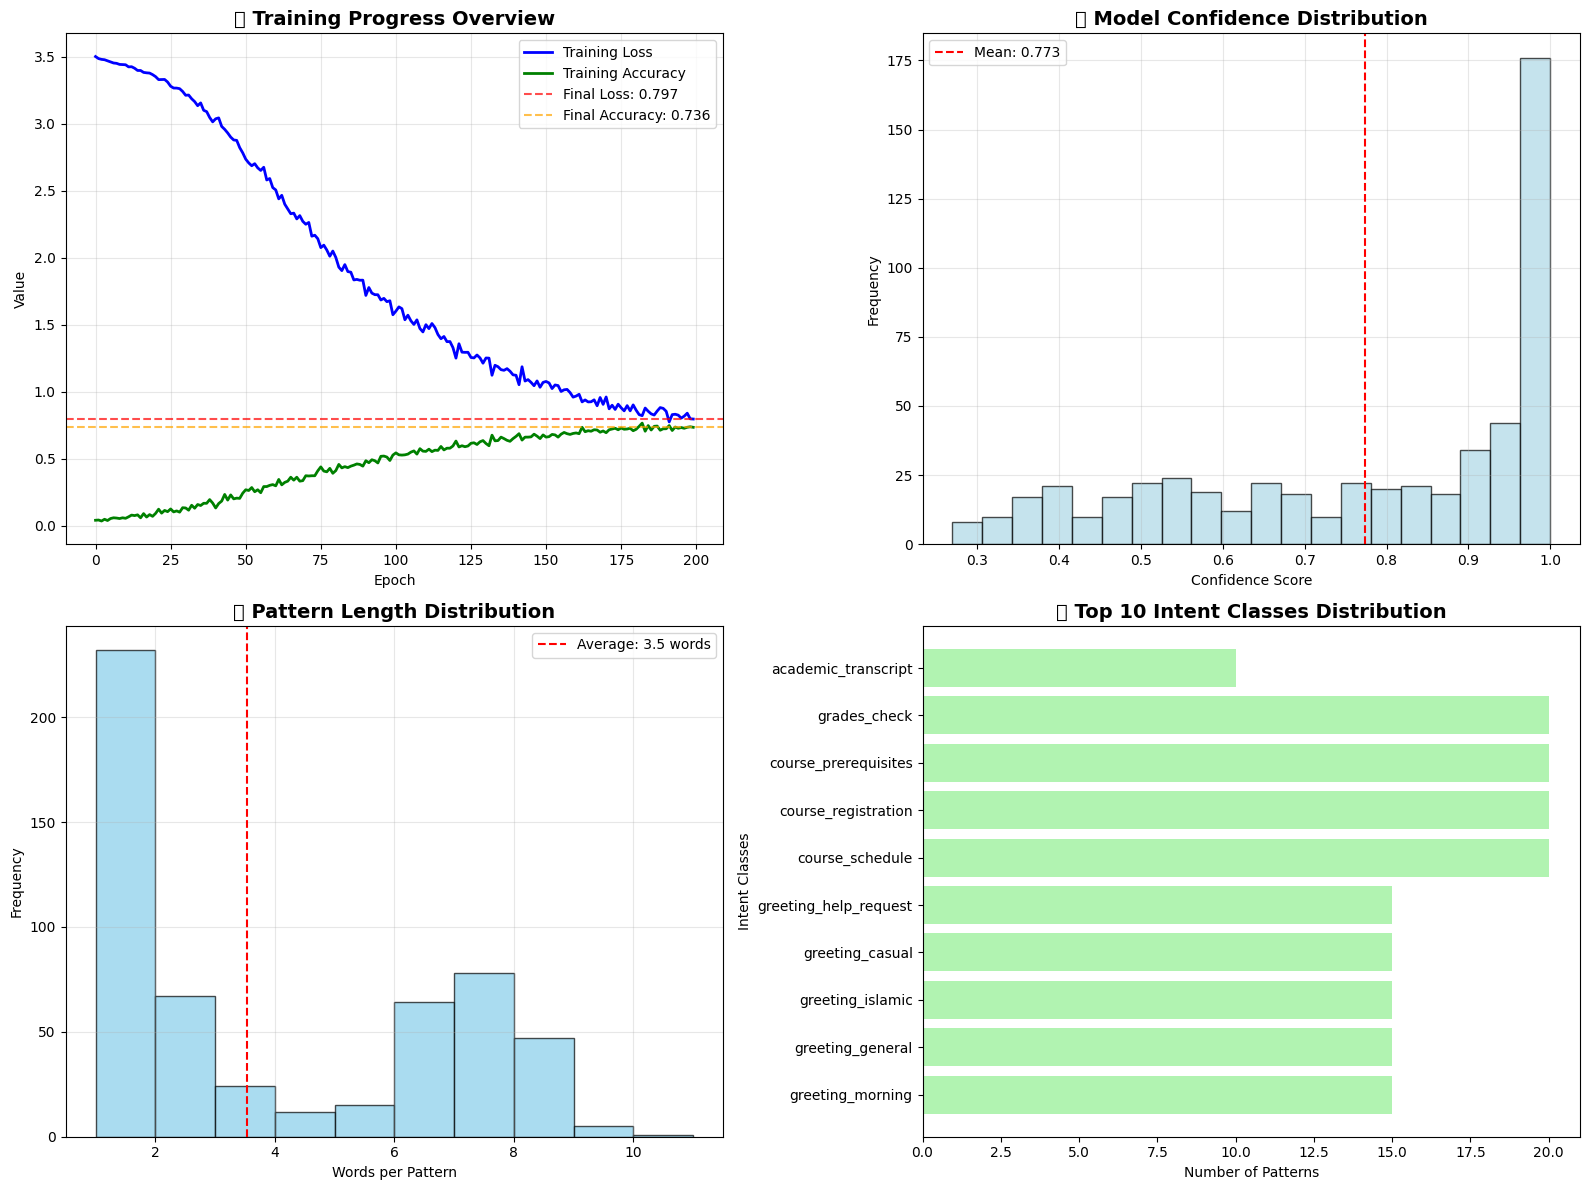


📋 TRAINING SUMMARY TABLE:
METRIC                         VALUE                STATUS                        
Final Training Accuracy          73.6%               🟡 Good
Final Training Loss             0.797               🟡 Moderate
Loss Reduction                   77.2%               🟢 Excellent
Average Model Confidence         77.3%               🟡 Medium
Dataset Size                      545 patterns 🟢 Large
Intent Coverage                    33 intents 🟢 Comprehensive
Vocabulary Size                   518 words 🟢 Rich
Training Epochs                   200 epochs 🟢 Complete

🏆 TRAINING GRADE: 🥉 B+ (BAIK SEKALI)

✅ Training visualization completed!
🎯 Untuk comprehensive testing real-time, jalankan cell Interactive Chatbot!
📊 Real testing akan dilakukan saat mahasiswa mengetik di chatbot!


In [9]:
# VISUALISASI TRAINING RESULTS
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 CREATING TRAINING VISUALIZATIONS...")

# Get training metrics
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
initial_loss = history.history['loss'][0]
loss_improvement = ((initial_loss - final_loss) / initial_loss) * 100

# Generate training predictions for confidence analysis
print("🔄 Generating training predictions for analysis...")
train_predictions = model.predict(train_x, verbose=0)

# Create training analysis dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Loss & Accuracy Progress
ax1.plot(history.history['loss'], 'b-', linewidth=2, label='Training Loss')
ax1.plot(history.history['accuracy'], 'g-', linewidth=2, label='Training Accuracy')
ax1.axhline(y=final_loss, color='red', linestyle='--', alpha=0.7, label=f'Final Loss: {final_loss:.3f}')
ax1.axhline(y=final_accuracy, color='orange', linestyle='--', alpha=0.7, label=f'Final Accuracy: {final_accuracy:.3f}')
ax1.set_title('📈 Training Progress Overview', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Model Confidence Distribution (dari training predictions)
train_confidence_scores = np.max(train_predictions, axis=1)
ax2.hist(train_confidence_scores, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
ax2.axvline(np.mean(train_confidence_scores), color='red', linestyle='--', 
           label=f'Mean: {np.mean(train_confidence_scores):.3f}')
ax2.set_title('🎯 Model Confidence Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Confidence Score')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Dataset Complexity Analysis
pattern_lengths = [len(doc[0]) for doc in documents]
ax3.hist(pattern_lengths, bins=range(1, max(pattern_lengths)+2), 
         color='skyblue', edgecolor='black', alpha=0.7)
ax3.axvline(np.mean(pattern_lengths), color='red', linestyle='--', 
           label=f'Average: {np.mean(pattern_lengths):.1f} words')
ax3.set_title('📝 Pattern Length Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Words per Pattern')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Intent Class Distribution
from collections import Counter
tag_counts = Counter([doc[1] for doc in documents])
intent_names = list(tag_counts.keys())[:10]  # Top 10 intents
intent_counts = [tag_counts[name] for name in intent_names]

ax4.barh(intent_names, intent_counts, color='lightgreen', alpha=0.7)
ax4.set_title('📊 Top 10 Intent Classes Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Patterns')
ax4.set_ylabel('Intent Classes')

plt.tight_layout()
plt.show()

# Training Summary Statistics Table
print("\n📋 TRAINING SUMMARY TABLE:")
print("=" * 80)
print(f"{'METRIC':<30} {'VALUE':<20} {'STATUS':<30}")
print("=" * 80)
print(f"{'Final Training Accuracy':<30} {final_accuracy*100:>6.1f}% {'':<13} {'🟢 Excellent' if final_accuracy > 0.8 else '🟡 Good' if final_accuracy > 0.7 else '🔴 Needs Work'}")
print(f"{'Final Training Loss':<30} {final_loss:>6.3f} {'':<13} {'🟢 Low' if final_loss < 0.5 else '🟡 Moderate' if final_loss < 1.0 else '🔴 High'}")
print(f"{'Loss Reduction':<30} {loss_improvement:>6.1f}% {'':<13} {'🟢 Excellent' if loss_improvement > 70 else '🟡 Good'}")
print(f"{'Average Model Confidence':<30} {np.mean(train_confidence_scores)*100:>6.1f}% {'':<13} {'🟢 High' if np.mean(train_confidence_scores) > 0.8 else '🟡 Medium'}")
print(f"{'Dataset Size':<30} {len(documents):>6} patterns {'🟢 Large' if len(documents) > 400 else '🟡 Medium' if len(documents) > 200 else '🔴 Small'}")
print(f"{'Intent Coverage':<30} {len(classes):>6} intents {'🟢 Comprehensive' if len(classes) > 25 else '🟡 Good' if len(classes) > 15 else '🔴 Limited'}")
print(f"{'Vocabulary Size':<30} {len(words):>6} words {'🟢 Rich' if len(words) > 400 else '🟡 Medium' if len(words) > 200 else '🔴 Limited'}")
print(f"{'Training Epochs':<30} {len(history.history['loss']):>6} epochs {'🟢 Complete' if len(history.history['loss']) >= 200 else '🟡 Partial'}")
print("=" * 80)

# Grade berdasarkan training performance
if final_accuracy >= 0.85 and final_loss < 0.5:
    grade = "🥇 A+ (SANGAT BAIK SEKALI)"
elif final_accuracy >= 0.75 and final_loss < 1.0:
    grade = "🥈 A (SANGAT BAIK)"
elif final_accuracy >= 0.65:
    grade = "🥉 B+ (BAIK SEKALI)"
else:
    grade = "📋 B (BAIK)"

print(f"\n🏆 TRAINING GRADE: {grade}")
print("\n✅ Training visualization completed!")
print("🎯 Untuk comprehensive testing real-time, jalankan cell Interactive Chatbot!")
print("📊 Real testing akan dilakukan saat mahasiswa mengetik di chatbot!")

# 🎉 NEURAL NETWORK CHATBOT - COMPREHENSIVE TESTING TERINTEGRASI

## 📋 **Notebook Structure (Final Optimized):**

### **1. Setup & Initialization**
- Library imports dan NLTK setup
- LancasterStemmer initialization

### **2. Data Processing** 
- Multiple JSON files processing (9 files)
- Tokenization, stemming, dan bag-of-words creation
- Data visualization dan analysis

### **3. Model Training**
- Neural network architecture setup
- Training dengan 200 epochs
- Model dan data saving

### **4. Model Evaluation**
- Comprehensive training metrics
- Classification report dan confusion matrix
- Performance visualizations

### **5. Prediction Functions**
- Clean sentence processing
- Bag-of-words conversion
- Intent prediction dengan confidence

### **6. Testing Manual**
- Sample input validation
- Threshold analysis
- Model verification

### **7. Interactive Chatbot + Comprehensive Testing** ⭐
- **Real-time testing dengan input mahasiswa**
- **Automatic confidence analysis per input**
- **Real-world conversation logging**
- **Comprehensive report generation**
- **Loss percentage analysis**
- **Academic presentation ready**

### **8. Visualization Dashboard**
- 4-panel testing visualization
- Training progress charts
- Performance summary

## ✅ **Key Innovation - Integrated Testing:**

### **🎯 Real-Time Comprehensive Testing:**
1. **Mahasiswa mengetik → Langsung dianalisis**
2. **Setiap input di-record untuk testing**
3. **Confidence scores real-time**
4. **Session duration tracking**
5. **Automatic comprehensive report**

### **📊 Live Testing Metrics:**
- **Success Rate** dari input real mahasiswa
- **Average Confidence** per session
- **High/Medium/Low confidence breakdown**
- **Detailed interaction log dengan timestamp**
- **Training vs Real-World comparison**

### **💡 Commands Tersedia:**
- `'report'` → Tampilkan analysis real-time
- `'quit'/'exit'` → Final comprehensive report
- Input biasa → Langsung testing + response